# Project 3 : Tumor Segmentation

We are going to try the three different techniques presented in the labs to segment the tumor:

* Thresholding
* Texture Segmentation
* Region Growing

We are first going to find the best technique using the provided image ($mri\_brain.jpg$), then we will test that technique on two new images: $tumor1.jpg$ and $tumor2.jpg$. We will see that the method works well for other images, if they use the same range of values as the given image, i.e.

* the background is very dark
* the tumor is quite bright
* the brain has values in-between

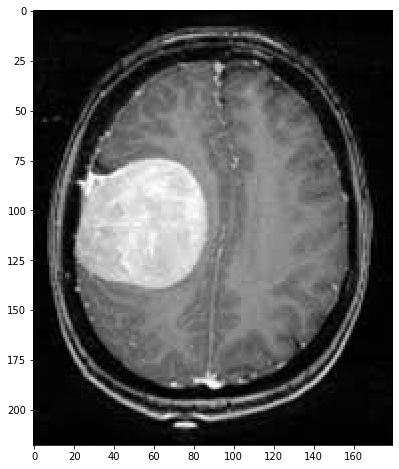

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

mri = imread("mri_brain.jpg")[:, :, 0]   # the image is grayscale, but encoded on 3 channels

plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(mri)
plt.show()

## 1. Thresholding

### 1.1 Automatic Thresholding (Otsu and optimal)

The algorithm for optimal threshold is quite simple: given a value $t$, we cut the histogram in two parts (before $t$, after $t$) and compute the centroid for each part. The new value for $t$ is the mean of the to centroids, and we repeat until $t$ converges. $t$ is then the optimal threshold. The final value of $t$ is independant of the initial value, but the number of iterations isn't.

Here, we see that the optimal threshold and the otsu threshold are very close, so we will only try one of them: otsu.

106
89
79
76
75
75
optimal: 75
otsu: 74


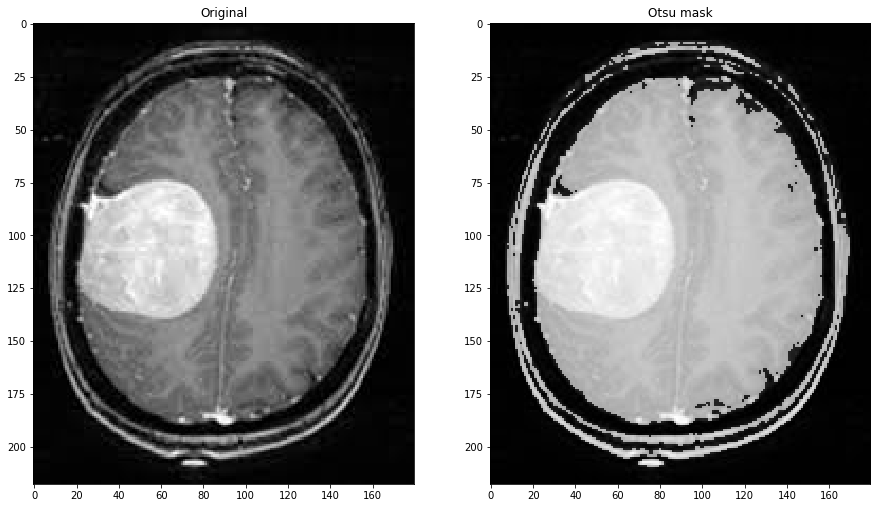

In [13]:
from skimage.filters import threshold_otsu

def hist(im):
    h = np.zeros((256,))
    for i in range(256):
        h[i] = (im==i).sum()
    return h

def centroid(h, imin, imax):
    num = 0 
    denom = 0
    
    for i in range(imin, imax+1):
        num += h[i]*i
        denom += h[i]
    
    return (num/denom)

def optimal(h, t):
    
    m1 = centroid(h, 0, t-1)
    m2 = centroid(h, t, 255)
    
    new_t = (m1 + m2) / 2
    
    new_t = int(round(new_t))
    print(new_t)

    
    if new_t == t:
        return new_t
    else:
        return optimal(h, new_t)
        
h = hist(mri)

t_opt = optimal(h, 127)
t_otsu = threshold_otsu(mri)

print("optimal:", t_opt)
print("otsu:", t_otsu)

mask_otsu = mri>t_otsu

plt.figure(figsize=(15, 16))
plt.subplot(1, 2, 1)
plt.imshow(mri)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(mri)
plt.imshow(mask_otsu, alpha=0.5)
plt.title("Otsu mask")
plt.show()

We see that the thresholding is very bad, and takes the whole image. We will try to pick a threshold manually.

### 1.2 Manual Thresholding

Let's pick a pixel in the tumor and another one somwhere else in the brain and see their values:

In [11]:
print(mri[100, 50]) #tumor
print(mri[100, 125]) #brain

217
135


We see a value of 217 and 135, so we will pick three initial thresholds: 150, 180, and 200.

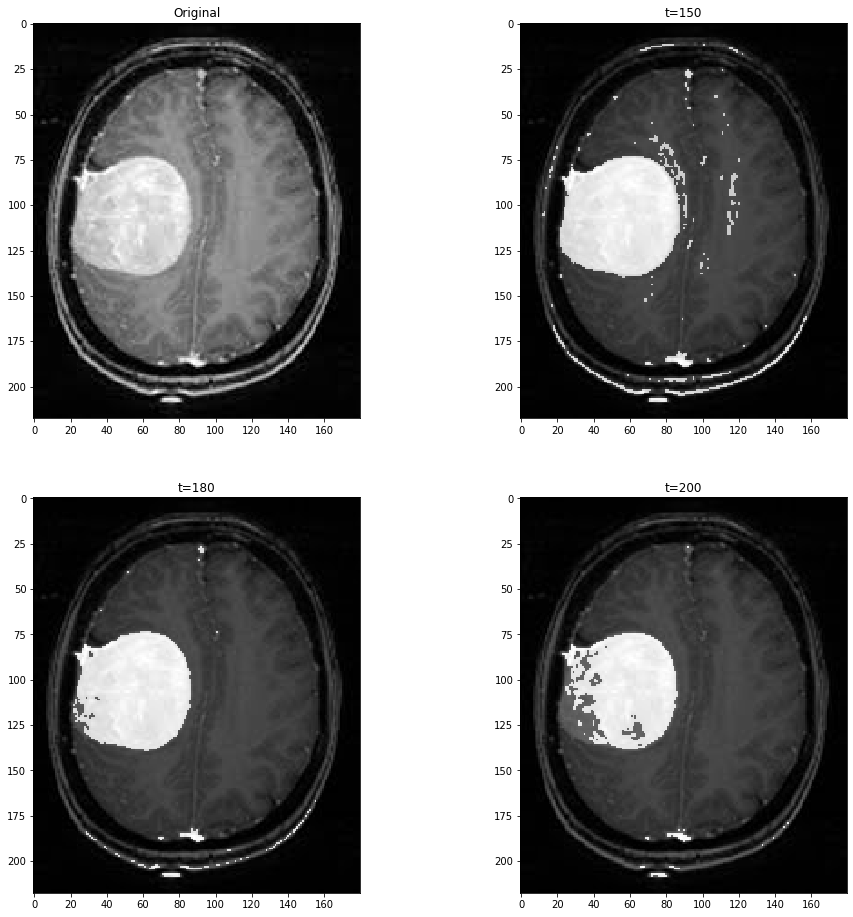

In [15]:
mask1 = mri > 150
mask2 = mri > 180
mask3 = mri > 200

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.imshow(mri)
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(mri)
plt.imshow(mask1, alpha=0.5)
plt.title("t=150")

plt.subplot(2,2,3)
plt.imshow(mri)
plt.imshow(mask2, alpha=0.5)
plt.title("t=180")

plt.subplot(2,2,4)
plt.imshow(mri)
plt.imshow(mask3, alpha=0.5)
plt.title("t=200")

plt.show()

We can see that:

* with 150, the tumor is almost perfectly segmented, but we pick up a lot of noise
* with 180, we are missing a small part of the tumor, but the noise is greatly reduced
* with 200, we are missing a large part of the tumor

We decude that 180 is the best of these. We could probably find a better value in those neighbourhoods, but we won't bother because we can already see that, while the result with $t=180$ is not too bad, it's not great either, and thresholding is thus probably not the best way to go.

## 2. Texture Segmentation

We will use the same algorithms that we saw in the labs, and the 6 properties of tha grayscale co-occurence matrix.

Contrast and Dissimilarity might work well, since they are good at detecting borders (they give more weight to values in the comatrix if they are further apart). 

Conversly, Homogeneity will probably not work very well, because it gives more weight to values closer together, so it will detect regions with very consistent values.

Similarly, ASM, Energy and Correlation detect regions with very similar values, so it will mostly pick up the background. 

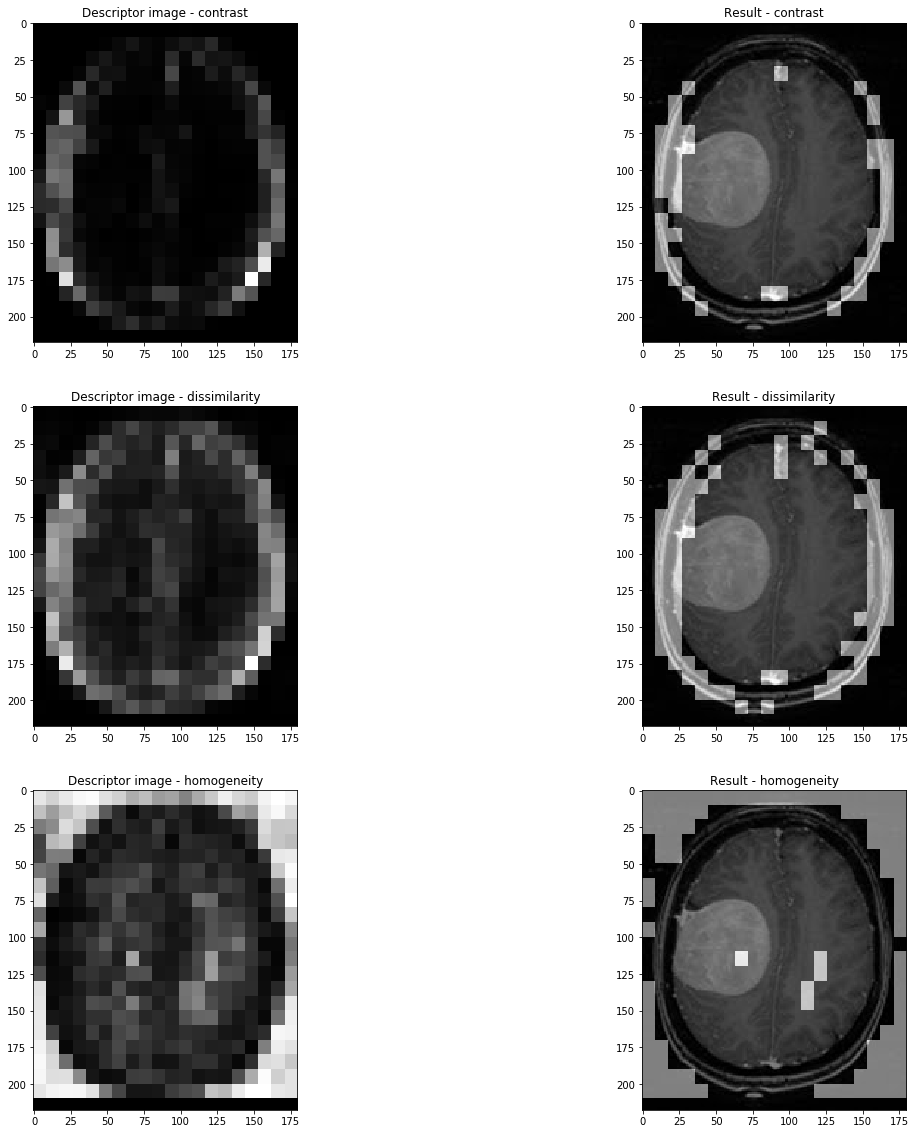

In [20]:
from skimage.feature import greycomatrix, greycoprops

def texture_descriptor(N, prop):
    comatrix = greycomatrix(N.astype('uint8'), [1], [0])
    prop_val = greycoprops(comatrix, prop=prop)[0, 0]
    return prop_val


def sliding_window(im, PATCH_SIZE, prop):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch, prop)
    return output

# Compute descriptor
im_descr_contrast = sliding_window(mri.astype('float'),(10, 9), "contrast")
im_descr_dissimilarity = sliding_window(mri.astype('float'),(10, 9), "dissimilarity")
im_descr_homogeneity = sliding_window(mri.astype('float'),(10, 9), "homogeneity")


# Threshold
T_contrast = threshold_otsu(im_descr_contrast)
T_dissimilarity = threshold_otsu(im_descr_dissimilarity)
T_homogeneity = threshold_otsu(im_descr_homogeneity)


# Build mask
mask_contrast = im_descr_contrast>T_contrast
mask_dissimilarity = im_descr_dissimilarity>T_dissimilarity
mask_homogeneity = im_descr_homogeneity>T_homogeneity



plt.figure(figsize=(20, 20))
plt.gray()
plt.subplot(3, 2, 1)
plt.imshow(im_descr_contrast)
plt.title('Descriptor image - contrast')
plt.subplot(3, 2, 2)
plt.imshow(mri)
plt.imshow(mask_contrast, alpha=0.5)
plt.title('Result - contrast')

plt.subplot(3, 2, 3)
plt.imshow(im_descr_dissimilarity)
plt.title('Descriptor image - dissimilarity')
plt.subplot(3, 2, 4)
plt.imshow(mri)
plt.imshow(mask_dissimilarity, alpha=0.5)
plt.title('Result - dissimilarity')

plt.subplot(3, 2, 5)
plt.imshow(im_descr_homogeneity)
plt.title('Descriptor image - homogeneity')
plt.subplot(3, 2, 6)
plt.imshow(mri)
plt.imshow(mask_homogeneity, alpha=0.5)
plt.title('Result - homogeneity')
plt.show()


As expected, Homogeneity was mostly useless. Contrast and Dissimilarity did a nice job of finding the borders of the brain, but that's not what we wanted. Finding the borders of the tumor would be harder, because the differences in the grayscale values are smaller than those for the borders of the brain. 

Let's try the same thing for the last three properties.

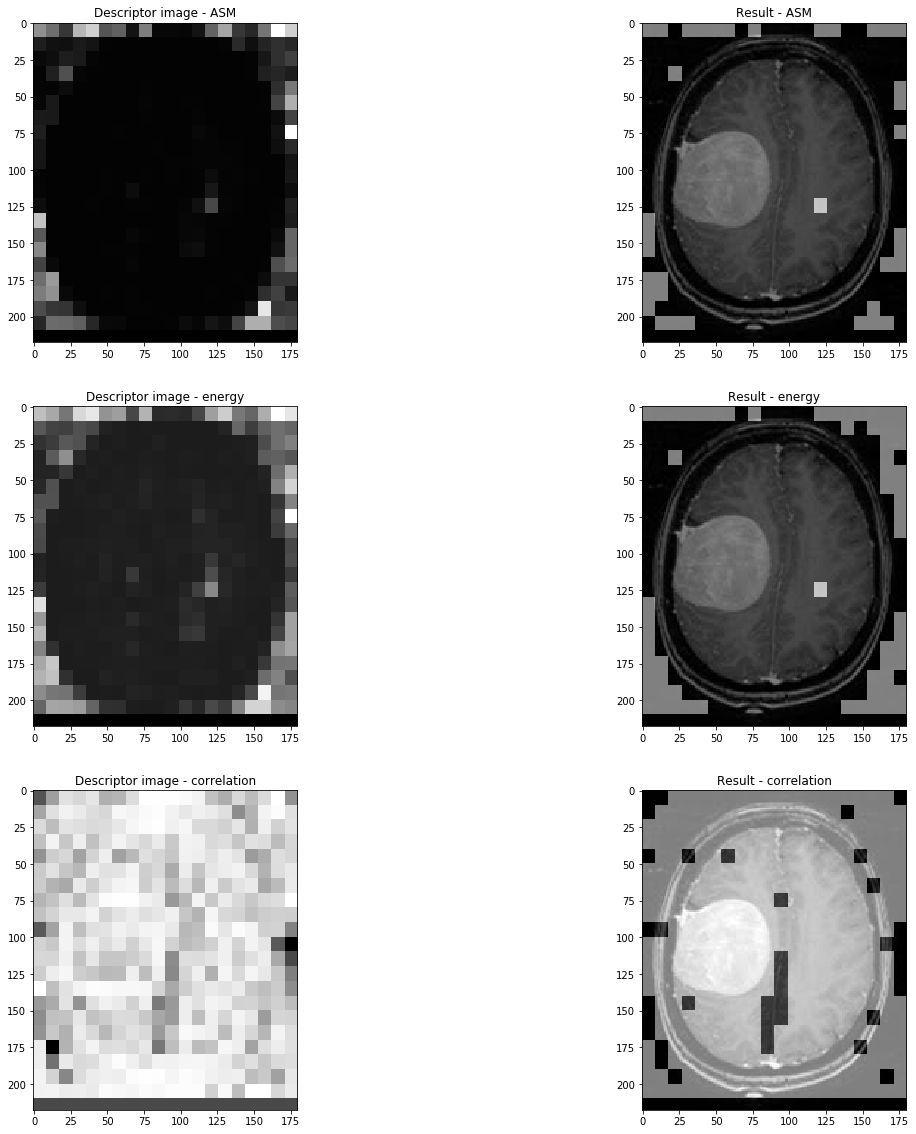

In [21]:

# Compute descriptor
im_descr_ASM = sliding_window(mri.astype('float'),(10, 9), "ASM")
im_descr_energy = sliding_window(mri.astype('float'),(10, 9), "energy")
im_descr_correlation = sliding_window(mri.astype('float'),(10, 9), "correlation")

# Threshold
T_ASM = threshold_otsu(im_descr_ASM)
T_energy = threshold_otsu(im_descr_energy)
T_correlation = threshold_otsu(im_descr_correlation)


# Build mask
mask_ASM = im_descr_ASM>T_ASM
mask_energy = im_descr_energy>T_energy
mask_correlation = im_descr_correlation>T_correlation



plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.imshow(im_descr_ASM)
plt.title('Descriptor image - ASM')
plt.subplot(3, 2, 2)
plt.imshow(mri)
plt.imshow(mask_ASM, alpha=0.5)
plt.title('Result - ASM')

plt.subplot(3, 2, 3)
plt.imshow(im_descr_energy)
plt.title('Descriptor image - energy')
plt.subplot(3, 2, 4)
plt.imshow(mri)
plt.imshow(mask_energy, alpha=0.5)
plt.title('Result - energy')

plt.subplot(3, 2, 5)
plt.imshow(im_descr_correlation)
plt.title('Descriptor image - correlation')
plt.subplot(3, 2, 6)
plt.imshow(mri)
plt.imshow(mask_correlation, alpha=0.5)
plt.title('Result - correlation')
plt.show()

As expected, those three didn't do what we wanted either. Once again, we will not bother "playing" with the parameters to see if we can have a better result, because it probably won't be very good anyway. Instead, we will move on to region growing, which looks more promising.

## 3. Region Growing

Here we will do the same thing as in the labs:

* Find markers for the different regions
* Compute gradient image
* Use watershed to grow regions based on the gradient and the markers
* Mark the boundaries of the tumor and the brain

### 3.1 Hand-picked markers

Here, we choose 3 markers: in the tumor, in the brain and in the background.

<Figure size 432x288 with 0 Axes>

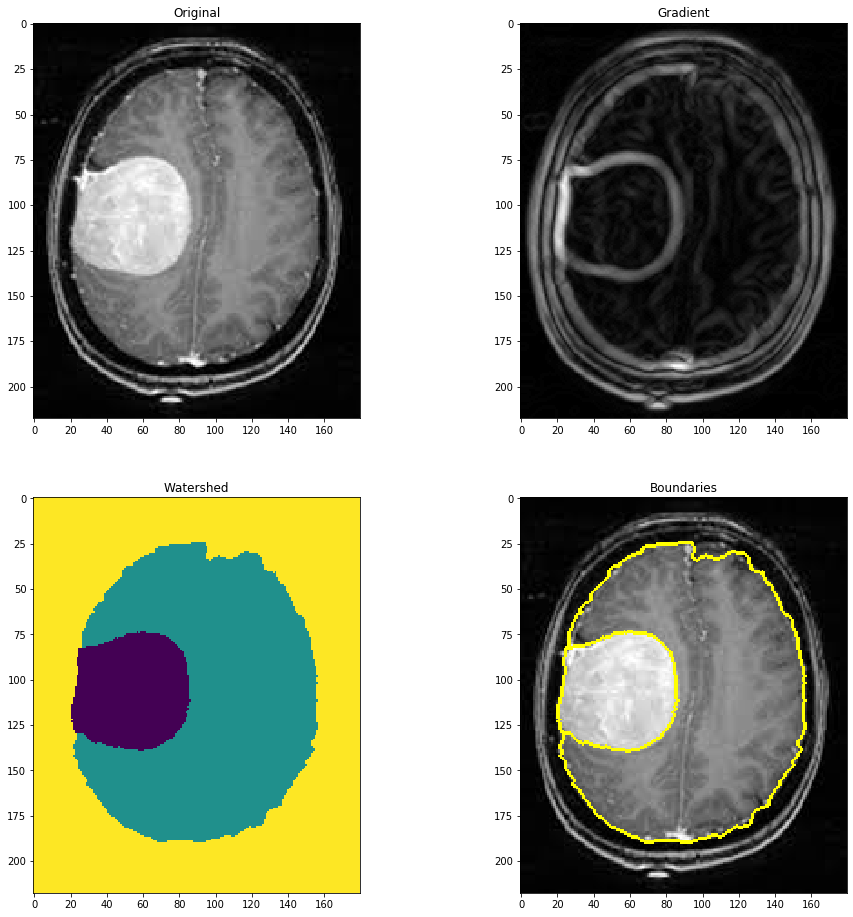

In [62]:
from skimage.morphology import watershed,disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries


smoothing_factor = 4

# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(mri, disk(smoothing_factor)), disk(1))

# Hand-picked markers
markers = np.zeros_like(mri)
markers[100,50] = 1 # in the tumor
markers[100,125] = 2 # in the brain
markers[25,175] = 3 # outside

ws = watershed(gradient, markers)

plt.set_cmap("viridis")  # for nice colors on the watershed image

plt.figure(figsize=(16, 16))

plt.subplot(2,2,1)
plt.imshow(mri,cmap=plt.cm.gray)
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.title("Gradient")

plt.subplot(2,2,3)
plt.imshow(ws)
plt.title("Watershed")

plt.subplot(2,2,4)
plt.imshow(mark_boundaries(mri,ws))
plt.title("Boundaries")

plt.show()

As expected, region growing gave us a really nice result, with the tumor and the brain almost perfectly segmented. However, we would like to have a way to automatically pick markers, so that the user doesn't have to do it manually.

### 3.2 Automatic marker picking

First, we will try the technique used in the labs, with the $peak\_local\_max$ function

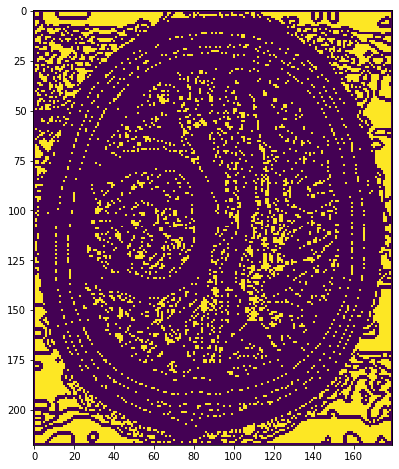

In [64]:
from skimage.feature import peak_local_max

gradient_i = gradient.max()-gradient # inverse gradient image so that local minima -> local maxima
markers = peak_local_max(gradient_i, indices=False)

plt.figure(figsize=(8, 8))
plt.imshow(markers)
plt.show()

There are too many markers, so we will try to restrict their quantity using a relative threshold and a minimal distance.

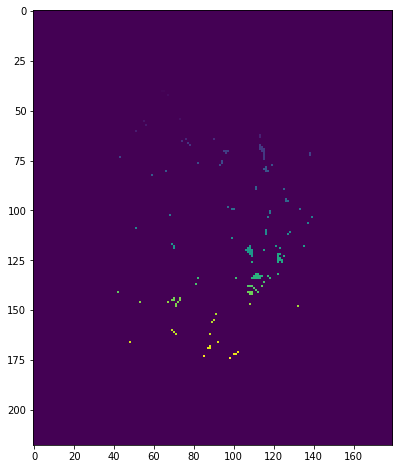

In [65]:
from skimage.measure import label

markers = label(peak_local_max(gradient_i, indices=False, threshold_rel=0.99, min_distance=40))

plt.figure(figsize=(8, 8))
plt.imshow(markers)
plt.show()

This is already much better, so let's try it:

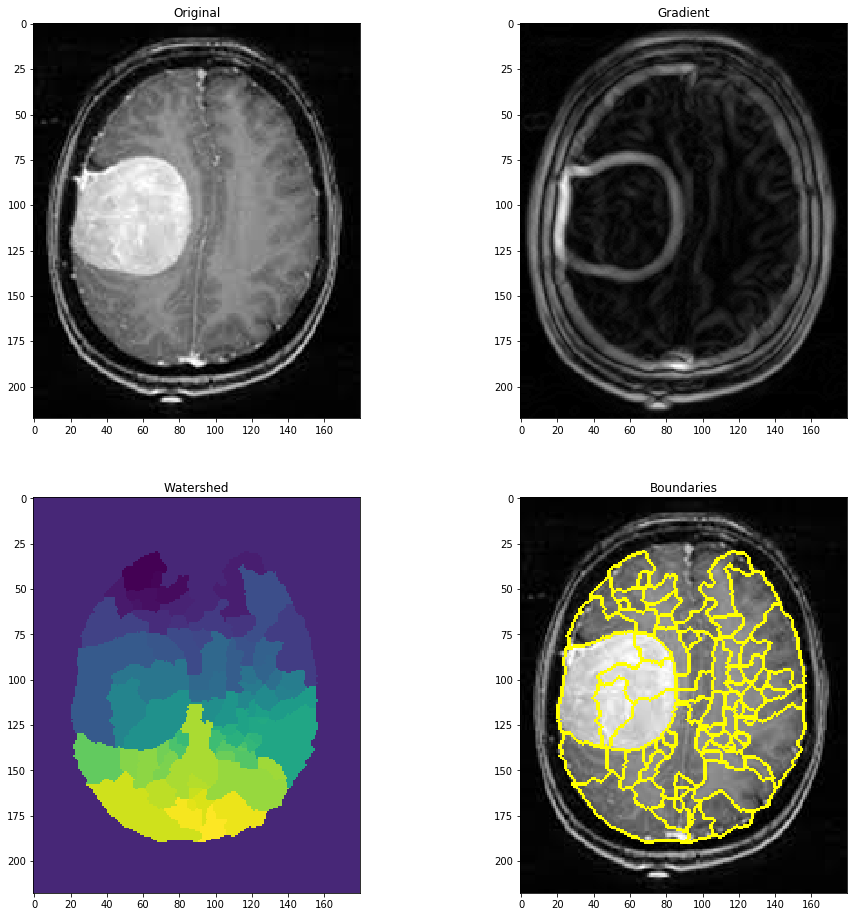

In [66]:
ws = watershed(gradient, markers)

plt.figure(figsize=(16, 16))

plt.subplot(2,2,1)
plt.imshow(mri,cmap=plt.cm.gray)
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.title("Gradient")

plt.subplot(2,2,3)
plt.imshow(ws)
plt.title("Watershed")

plt.subplot(2,2,4)
plt.imshow(mark_boundaries(mri,ws))
plt.title("Boundaries")

plt.show()


It's not too bad, but the high number of regions means that there is more than one region for the tumor, which is not what we want. We could maybe use the $num\_peaks$ parameter to limit the number of peaks to have only one region for the tumor.

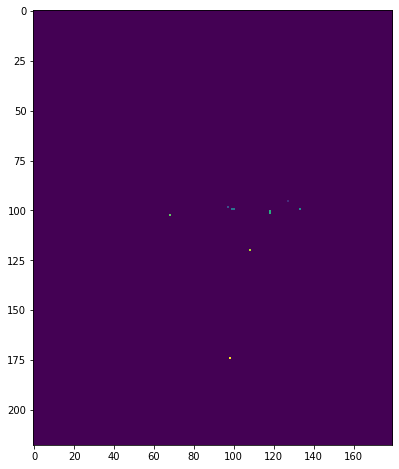

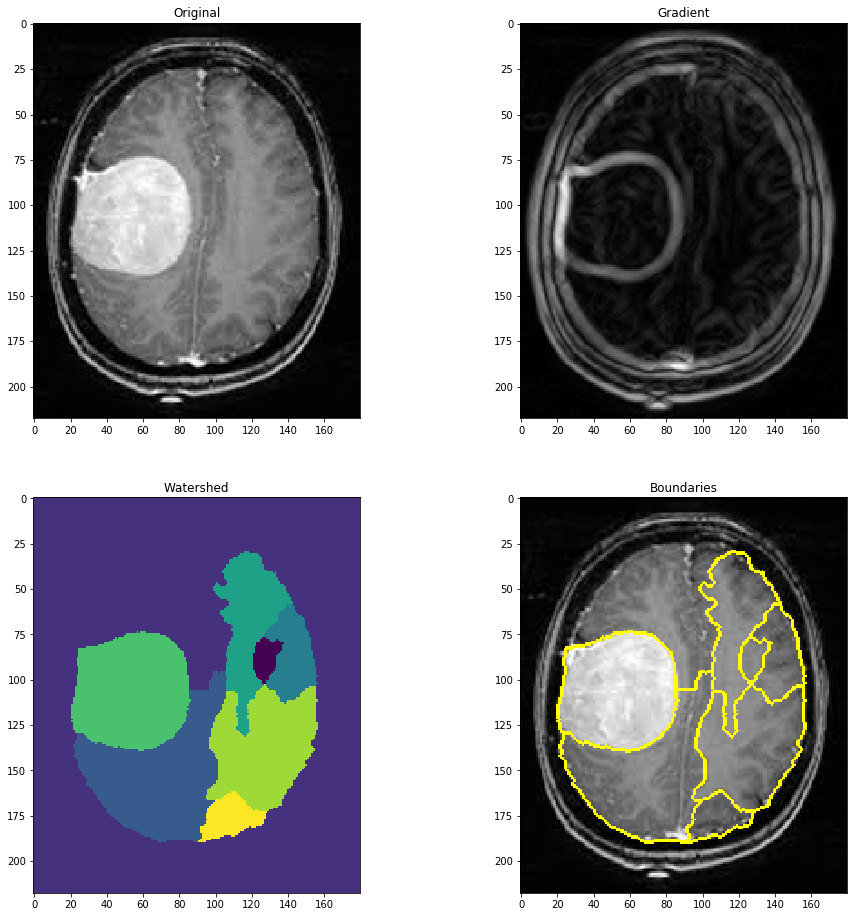

In [67]:
markers = label(peak_local_max(gradient_i, indices=False, num_peaks=10, threshold_rel=0.99, min_distance=40))

plt.figure(figsize=(8, 8))
plt.imshow(markers)
plt.show()

ws = watershed(gradient, markers)

plt.figure(figsize=(16, 16))

plt.subplot(2,2,1)
plt.imshow(mri,cmap=plt.cm.gray)
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.title("Gradient")

plt.subplot(2,2,3)
plt.imshow(ws)
plt.title("Watershed")

plt.subplot(2,2,4)
plt.imshow(mark_boundaries(mri,ws))
plt.title("Boundaries")

plt.show()

The results are quite good, and allow us to segment the tumor and estimate its size. However, we would like to have the same result as the hand-picked markers, i.e. 3 regions: tumor, brain, background.

The predefined functions are too general to allow us to do that, so we will have to make one ourselves. It will only work for tumors, and only if they use the same range of values as this image (see introduction).


This method is inspired by the sliding window of texture growing: the function takes as parameters a value, a lower tolerance, a higher tolerance, and a window size. A window of the given size will slide on the image, and for each window, if $$value - low\_tol \leq pixel \leq value + high\_tol \qquad \forall\; pixel\; in\; window$$ then the center of the window will be added to list of markers that will be returned by the function.

This function will be called 3 times:

* for the tumor with condition $max\_val - 50 \leq pixel \leq max\_val$
* for the background with condition $min\_val \leq pixel \leq min\_val + 30$
* for the brain with condition $mean\_val - 50 \leq pixel \leq mean\_val + 50$

$max\_val$ is the maximum value in the image, $min\_val$ is the minimun value in the image, and $mean\_val$ is the mean of the two.

The tolerances for the background are smaller because the values of the pixels there are very close.

This gives us a list of markers for each region. Let's plot them on the image and see the results.


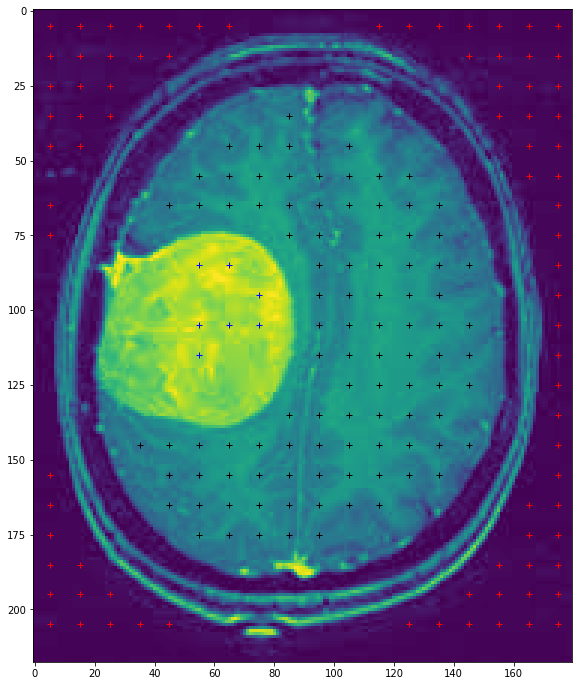

In [48]:
def find_region(im, value, low_tol, high_tol, window_size):
    width = im.shape[1]//window_size[1]
    height = im.shape[0]//window_size[0]
    
    markers = []
    
    for y in range(height):
        for x in range(width):
            window = im[y*window_size[0]:(y+1)*window_size[0], x*window_size[1]:(x+1)*window_size[1]]
            
            mask_low = (value - low_tol <= window) 
            mask_high = (window <= value+high_tol)
            
            mask = mask_low*mask_high  # multiplying is like mask_low AND mask_high
            
            size = window_size[0]*window_size[1]
            
            if(mask.sum() == size):
                coord_y = round((y + 0.5)*window_size[0])  # coordinates of the center of the window
                coord_x = round((x + 0.5)*window_size[1])
                markers.append([coord_y, coord_x])
                
    return np.array(markers)
            
    
max_val = mri.max()
min_val = mri.min()
mean = round((max_val+min_val)/2)

mark_tumor = find_region(mri, max_val, 50, 50, (10, 10))
mark_brain = find_region(mri, mean, 50, 50, (10, 10))
mark_out = find_region(mri, min_val, 30, 30, (10, 10))


plt.figure(figsize=(12, 12))
plt.imshow(mri)
plt.plot(mark_tumor[:, 1], mark_tumor[:, 0], 'b+')

plt.plot(mark_brain[:, 1], mark_brain[:, 0], 'k+')

plt.plot(mark_out[:, 1], mark_out[:, 0], 'r+')
plt.show()


We can see that the result is quite good, since not a single marker is incorrectly positioned. With these arrays of coordinates, the rest is simple: we create the $markers$ array, and for each coordinate in a given list, we put the same values in $markers$. This will let watershed method know that all markers that we see in the same color in the previous image are to be considered in the same color. We will thus have only three regions.

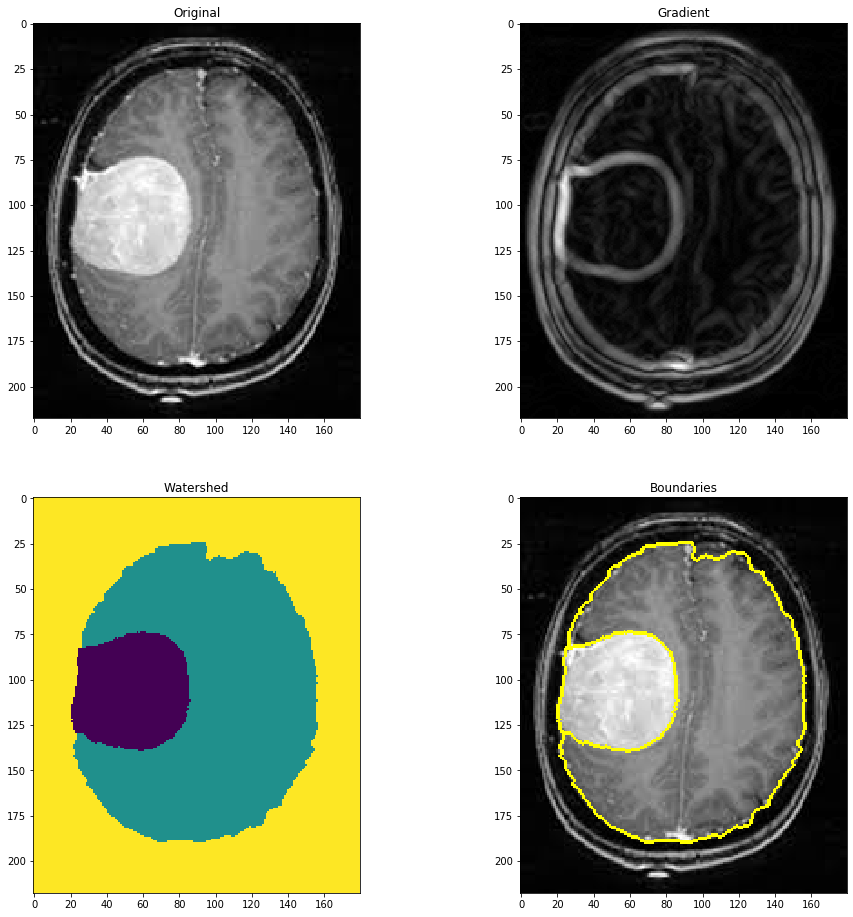

In [68]:
smoothing_factor = 4

# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(mri, disk(smoothing_factor)), disk(1))

markers = np.zeros_like(mri)
markers[mark_tumor[:,0], mark_tumor[:,1]] = 1 # in the tumor
markers[mark_brain[:,0], mark_brain[:,1]] = 2 # in the brain
markers[mark_out[:,0], mark_out[:,1]] = 3     # background


ws = watershed(gradient, markers)

plt.figure(figsize=(16, 16))
plt.subplot(2,2,1)
plt.imshow(mri,cmap=plt.cm.gray)
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.title("Gradient")

plt.subplot(2,2,3)
plt.imshow(ws)
plt.title("Watershed")

plt.subplot(2,2,4)
plt.imshow(mark_boundaries(mri,ws))
plt.title("Boundaries")

plt.imshow(mark_boundaries(mri,ws));

And we can see that we have exactly what we wanted. From there, it is easy to compute the size of the tumor, and even the percentage of the brain it represents, since we have also segmented the brain. In $the markers$ array, we gave the tumor values $1$ and the brain values $2$, so we can just select pixels that have those values in the watershed image.

In [79]:
tumor = (ws==1) # binary array with ones where ws==1 and zeros everywhere else
brain = (ws==2)

scale = 0.115*0.115

tumor_size = scale*tumor.sum()
brain_size = scale*brain.sum()

print("tumor size:", tumor_size, "cm^2")
print("brain size:", brain_size, "cm^2")
print("tumor percentage of brain: ", (100*tumor_size)/(tumor_size + brain_size), "%")

tumor size: 46.2875 cm^2
brain size: 189.01170000000002 cm^2
tumor percentage of brain:  19.671762589928058 %


### 3.3 Test on other images

We can now put all of that in a single function to test our algorithm on other images. We will use the following two images:

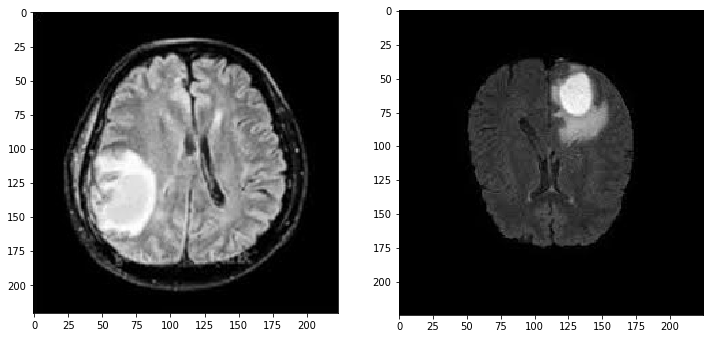

In [57]:
tumor1 = imread("tumor1.jpg")[:, :, 0] #grayscale images with three identical channels, we take only 1
tumor2 = imread("tumor2.jpg")[:, :, 0]

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(tumor1, cmap=plt.cm.gray)

plt.subplot(1, 2, 2)
plt.imshow(tumor2, cmap=plt.cm.gray)

plt.show()

The segmentation function takes as parameters only the image and the scale of the image, so the user has almost nothing to do.

We do not know the scales of the two test images, so we will assume it is the same as the given image.

In [73]:
def find_region(im, value, low_tol, high_tol, window_size):
    width = im.shape[1]//window_size[1]
    height = im.shape[0]//window_size[0]
    
    markers = []
    
    for y in range(height):
        for x in range(width):
            window = im[y*window_size[0]:(y+1)*window_size[0], x*window_size[1]:(x+1)*window_size[1]]
            mask_low = (value - low_tol <= window) 
            mask_high = (window <= value+high_tol)
            mask = mask_low*mask_high
            size = window_size[0]*window_size[1]
            if(mask.sum() == size):
                coord_y = round((y + 0.5)*window_size[0])
                coord_x = round((x + 0.5)*window_size[1])
                markers.append([coord_y, coord_x])
    return np.array(markers)
            


def compute_area(ws, scale):
    tumor = (ws==1)
    brain = (ws==2)

    tumor_size = scale*tumor.sum()
    brain_size = scale*brain.sum()

    print("tumor_size:", tumor_size, "cm^2")
    print("brain_size:", brain_size, "cm^2")
    print("tumor percentage:", (100*tumor_size)/(tumor_size + brain_size), "%")
    
def tumor_segmentation(im, scale):
    max_val = im.max()
    min_val = im.min()
    mean = round((max_val+min_val)/2)
    
    
    mark_tumor = find_region(im, max_val, 50, 50, (10, 10))
    mark_brain = find_region(im, mean, 50, 50, (10, 10))
    mark_out = find_region(im, min_val, 30, 30, (10, 10))
    
    
    markers = np.zeros_like(im)
    markers[mark_tumor[:,0], mark_tumor[:,1]] = 1 # in the tumor
    markers[mark_brain[:,0], mark_brain[:,1]] = 2 # in the brain
    markers[mark_out[:,0], mark_out[:,1]] = 3     # backround
    
    
    smoothing_factor = 4

    gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))
    
    ws =  watershed(gradient, markers)
    compute_area(ws, scale)
    
    plt.figure(figsize=(16, 16))
    
    plt.subplot(2,2,1)
    plt.imshow(im,cmap=plt.cm.gray)
    plt.title("Original")

    plt.subplot(2,2,2)
    plt.imshow(gradient,cmap=plt.cm.gray)
    plt.title("Gradient")

    plt.subplot(2,2,3)
    plt.imshow(ws)
    plt.title("Watershed")

    plt.subplot(2,2,4)
    plt.imshow(mark_boundaries(im,ws))
    plt.title("Boundaries")
    
    plt.show()

tumor_size: 33.35345 cm^2
brain_size: 200.04135000000002 cm^2
tumor percentage: 14.290571169537623 %


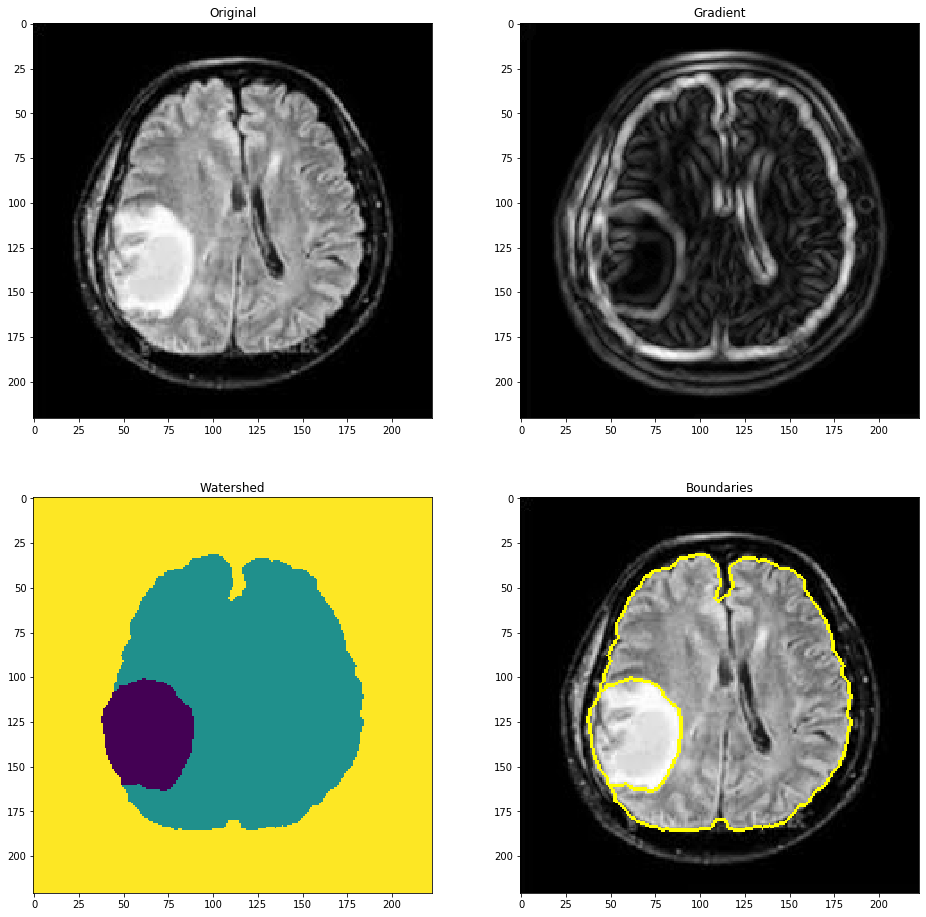

In [80]:
mri_2 = imread("tumor1.jpg")[:, :, 0]


tumor_segmentation(mri_2, 0.115*0.115)

We can see that it works quite well for the second image. For the third one, the function will fail because it won't be able to find any markers for the brain, since the values there are much lower than for the first two images. This can be solved with a very quick gamma correction: 

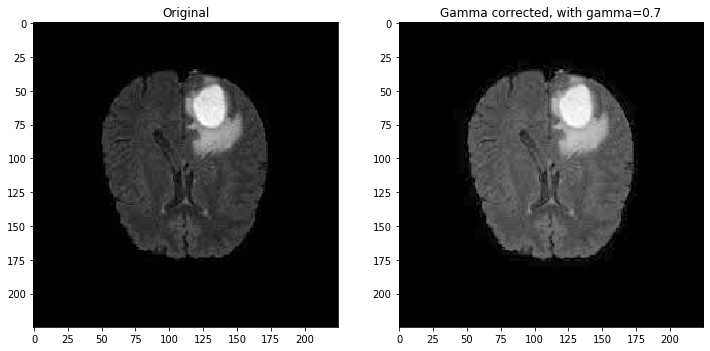

In [77]:
mri_3 = imread("tumor2.jpg")[:, :, 0]

def gamma_correction(im, gamma=1):
    im2 = (im.copy()).astype('float64')
    im2 /= 255
    im2 = im2**gamma
    im2 = np.round(im2*255)
    return im2.astype('uint8')

mri_3_corrected = gamma_correction(mri_3, 0.7)

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(mri_3, cmap=plt.cm.gray)
plt.title("Original")


plt.subplot(1, 2, 2)
plt.imshow(mri_3_corrected, cmap=plt.cm.gray)
plt.title("Gamma corrected, with gamma=0.7")

plt.show()

tumor_size: 8.5698 cm^2
brain_size: 174.953525 cm^2
tumor percentage: 4.669597175181956 %


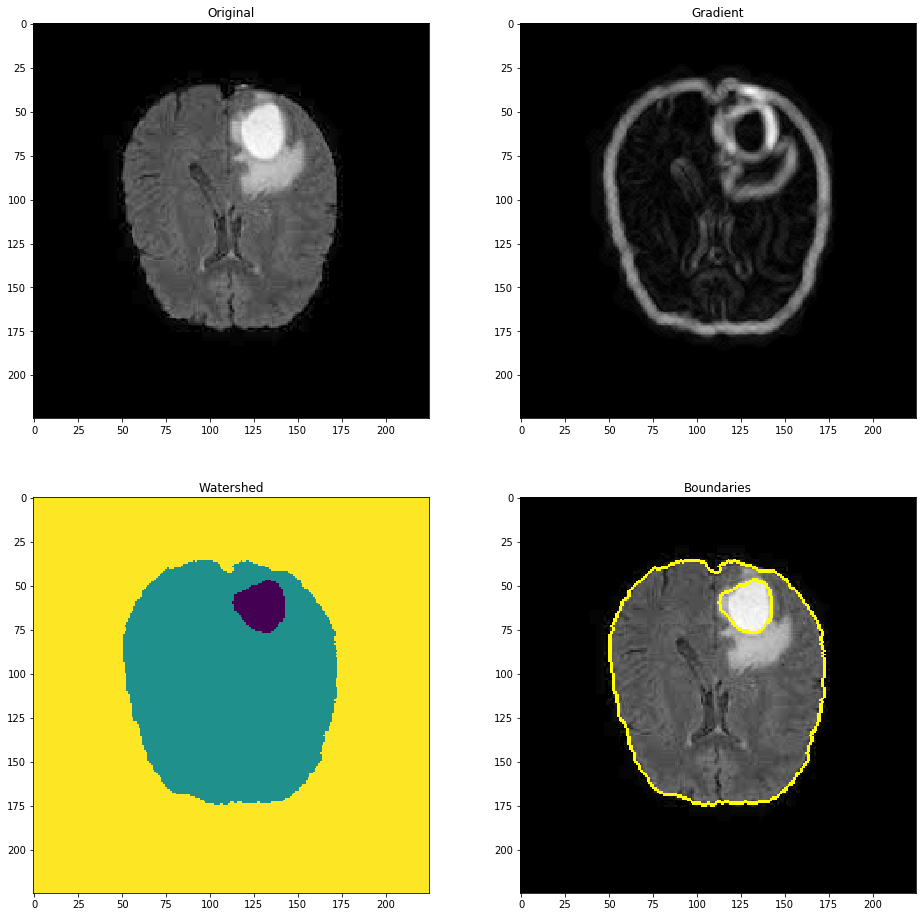

In [81]:
tumor_segmentation(mri_3_corrrected, 0.115*0.115)

Here again, it works reasonably well. There are, of course, imporvements to be made:

* The gamma correction could be made automatically if no markers are found. Alternatively, the function could accept a window if it has a high enough percentage of accepted pixels (instead of all the pixels).

* In the third image, there is a part that is brighter than the brain, but darker than the tumor, and it is considered in the brain by the algorithm. However, it's probably part of the tumor, and we could try adapt to the parameters to count it as such.